In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import pathlib

import matplotlib

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.autolayout'] = True

font = {'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.use("pgf")

import os
import sys
os.chdir('..')
sys.path.insert(0, '..')

from trlfpi.report import Report

In [2]:
def highlight(s):
    '''
    highlight the best in a Series yellow.
    '''
    
    is_min = abs(s) == abs(s).min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [3]:
def importExperimentData(experimentNames):
    experiments = []
    rewards = []
    eval_rewards = []
    test_rewards = []
    actor_loss = []
    critic_loss = []
    for path, name, size, horizon in experimentNames:
        
        report = Report(f"./results/{path}")
        for i in report.listExisting():
            report.id(i)
            variables = report.unpickle('variables')
            rewards.append(variables['reward'][0])
            eval_rewards.append(variables['eval_reward'][0])
            actor_loss.append(variables['actor_loss'][0])
            if 'critic_loss' in variables:
                critic_loss.append(variables['critic_loss'][0])
            elif 'c1_loss' in variables:
                critic_loss.append(variables['c1_loss'][0])
            test_rewards.append(variables['test_reward'][0])
            experiments.append({
                'name': name,
                'iteration': i,
                'size': size,
                'horizon': horizon
            })
            
    evalRewardDF = pd.DataFrame(eval_rewards)
    evalRewardDF = evalRewardDF.rename(lambda x: x*10, axis='columns')

    expDF, rewardDF, testRewardDF, actorDF, criticDF = list(map(lambda x: pd.DataFrame(x), [experiments, rewards, test_rewards, actor_loss, critic_loss]))
    
    rewardDF = pd.concat([expDF, rewardDF], axis=1, join='inner')
    evalRewardDF = pd.concat([expDF, evalRewardDF], axis=1, join='inner')
    testRewardDF = pd.concat([expDF, testRewardDF], axis=1, join='inner')
    actorDF = pd.concat([expDF, actorDF], axis=1, join='inner')
    criticDF = pd.concat([expDF, criticDF], axis=1, join='inner')
    
    columnFilter = ['name', 'iteration', 'size', 'horizon']
    expDF['bestTestScore'] = testRewardDF.drop(columnFilter, axis=1).max(axis=1)
    expDF['bestTestIdx'] = testRewardDF.drop(columnFilter, axis=1).T.idxmax()
    expDF['meanTestScore'] = testRewardDF.drop(columnFilter, axis=1).mean(axis=1)
    expDF['bestEvalScore'] = evalRewardDF.drop(columnFilter, axis=1).max(axis=1)
    expDF['bestEvalEp'] = evalRewardDF.drop(columnFilter, axis=1).T.idxmax()

    compTableHorizonDF = expDF.drop(['iteration', 'bestTestIdx', 'bestEvalScore'], axis=1).groupby(['name', 'horizon']).agg({
        'bestTestScore': ['max'],
        'meanTestScore': ['mean', 'std'],
        'bestEvalEp': ['min', 'mean', 'std']
    })
    
    compTableNamesDF = expDF.drop(['iteration', 'bestTestIdx', 'bestEvalScore'], axis=1).groupby(['name']).agg({
        'bestTestScore': ['max'],
        'meanTestScore': ['mean', 'std'],
        'bestEvalEp': ['min', 'mean', 'std']
    })
    return compTableHorizonDF, compTableNamesDF, expDF, rewardDF, evalRewardDF, testRewardDF, actorDF, criticDF
    

In [4]:
from scipy import stats

def smoothMean(df, epsilon: float = 2.0):
    tmpDF = df.drop(['name', 'iteration', 'size', 'horizon'], axis=1)
    mask = np.abs(tmpDF.apply(stats.zscore)) < epsilon
    return tmpDF[mask].mean()

# PPO with Future Inputs

In [5]:
compHorizonDF, compNamesDF, expDF, rewardDF, evalRewardDF, testRewardDF, actorDF, criticDF = importExperimentData([
      ('0_PPO_b', 'PPO', 'b', '3'),
      ('0_DPPO_b', 'DPPO', 'b', '3'),
      ('0_MAPPO_b', 'MAPPO', 'b', '3'),
      ('0_TPPO_b', 'TPPO', 'b', '3'),
      ('0_TDPPO_b', 'TDPPO', 'b', '3'),
      ('0_TMAPPO_b', 'TMAPPO', 'b', '3'),
      ('1_PPO_b', 'PPO', 'b', '1'),
      ('1_DPPO_b', 'DPPO', 'b', '1'),
      ('1_MAPPO_b', 'MAPPO', 'b', '1'),
      ('1_TPPO_b', 'TPPO', 'b', '1'),
      ('1_TDPPO_b', 'TDPPO', 'b', '1'),
      ('1_TMAPPO_b', 'TMAPPO', 'b', '1'),
      ('2_PPO_b', 'PPO', 'b', '5'),
      ('2_DPPO_b', 'DPPO', 'b', '5'),
      ('2_MAPPO_b', 'MAPPO', 'b', '5'),
      ('2_TPPO_b', 'TPPO', 'b', '5'),
      ('2_TDPPO_b', 'TDPPO', 'b', '5'),
      ('2_TMAPPO_b', 'TMAPPO', 'b', '5')
])
compNamesDF.style.apply(highlight)

In [6]:
compHorizonDF.loc[['TMAPPO']].style.apply(highlight)

In [7]:
compHorizonDF.loc[['MAPPO', 'TMAPPO']].style.apply(highlight)

## Evaluation plot

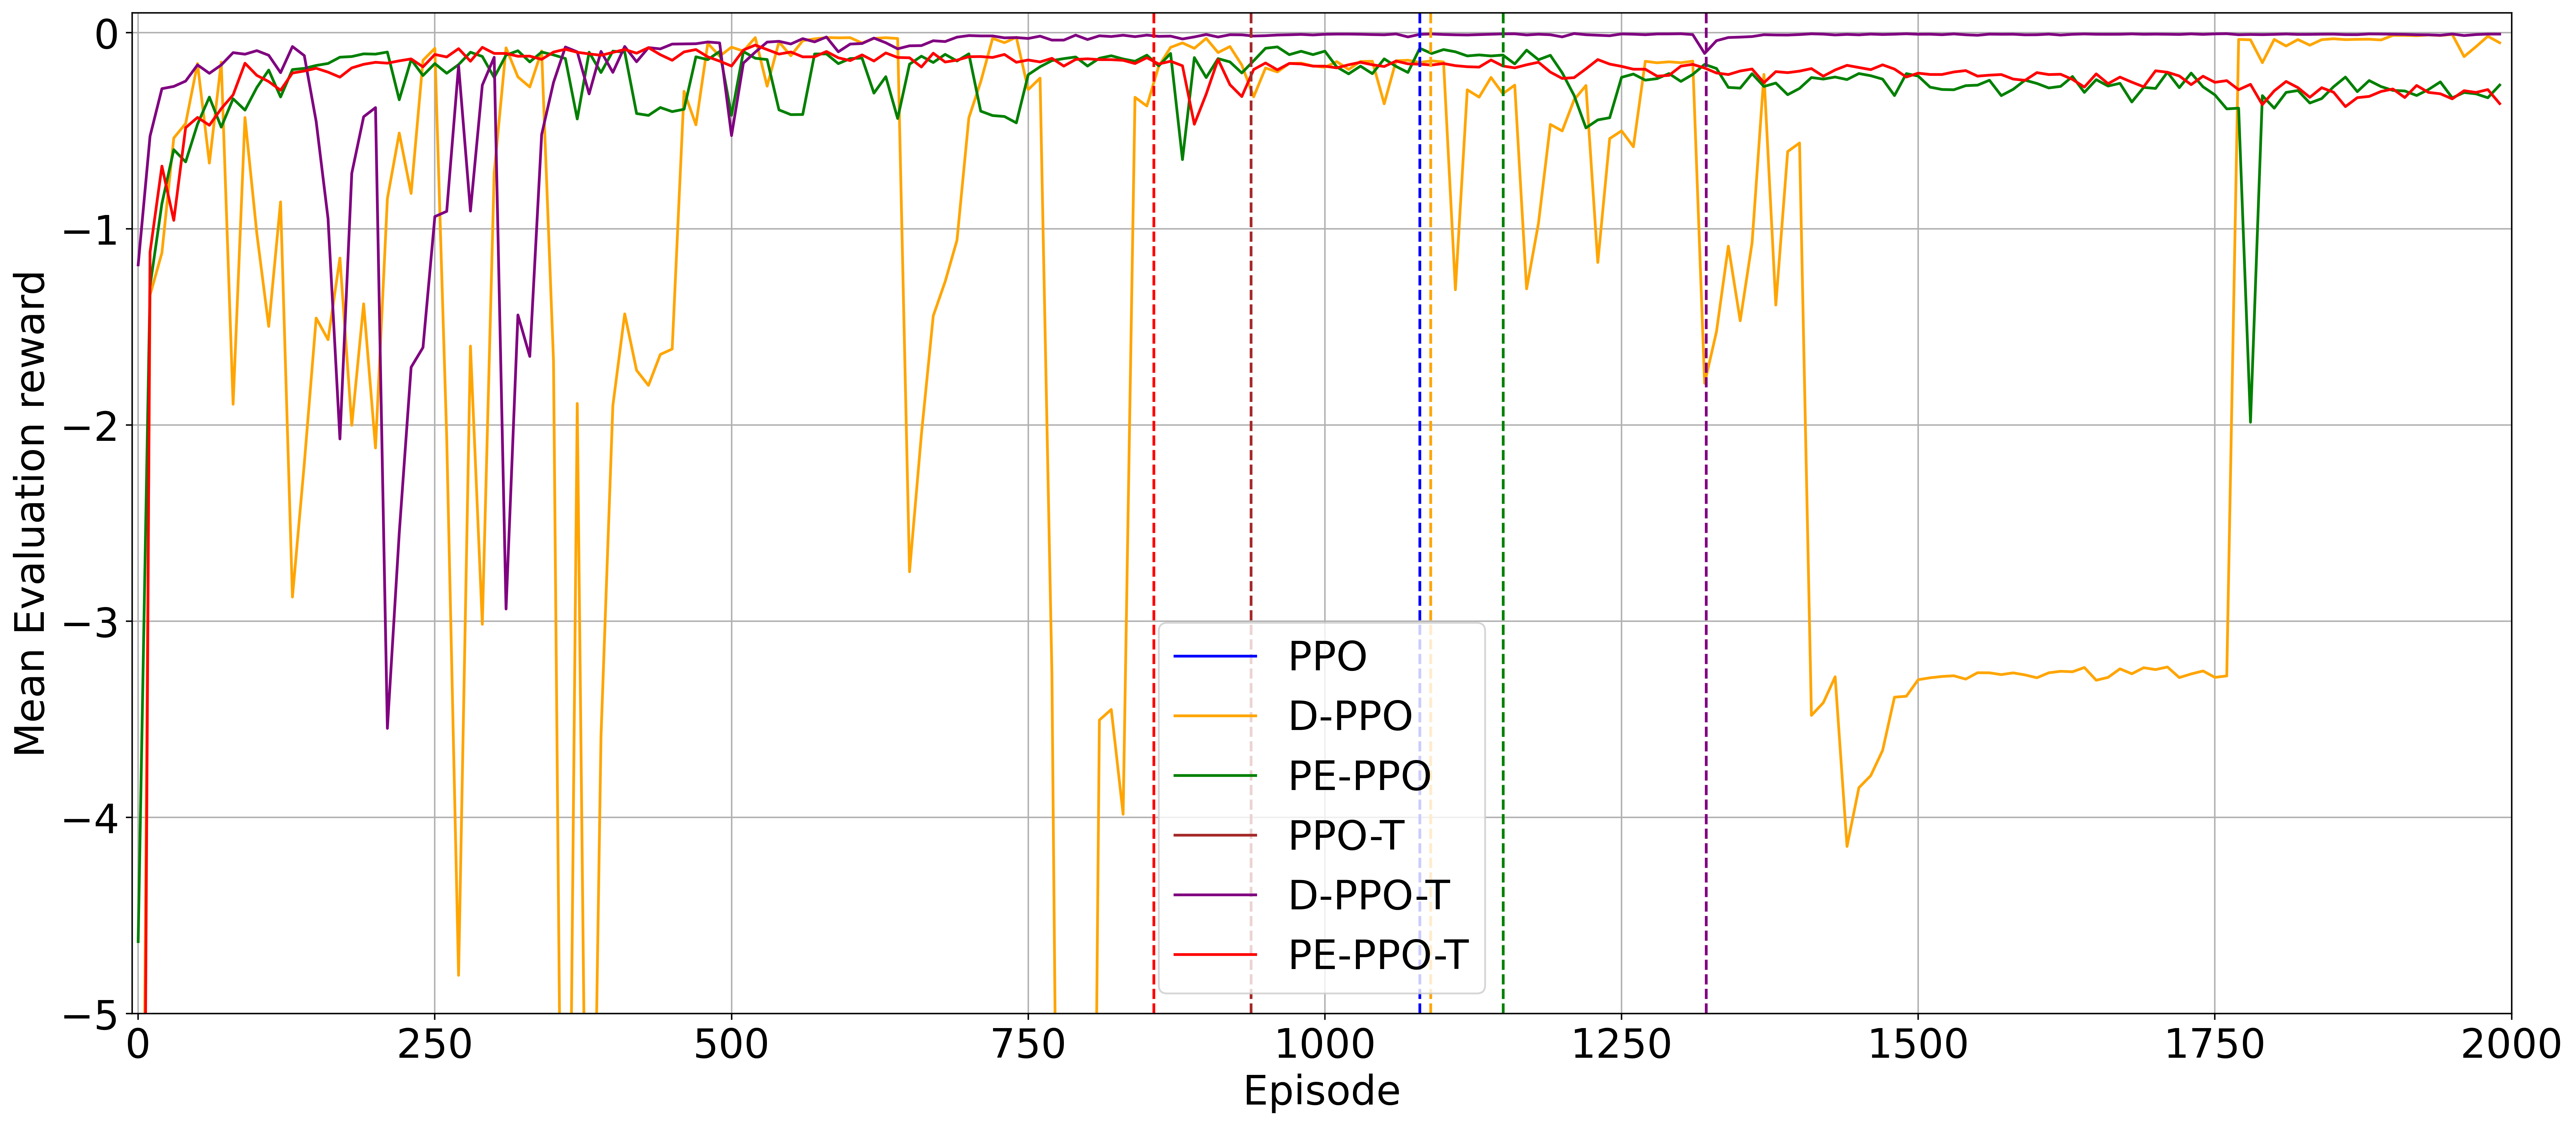

In [8]:
fig = plt.figure(figsize=(20, 9))
plt.plot(smoothMean(evalRewardDF.loc[evalRewardDF['name'] == 'PPO'], 2), color='blue')
plt.plot(smoothMean(evalRewardDF.loc[evalRewardDF['name'] == 'DPPO'], 2), color='orange')
plt.plot(smoothMean(evalRewardDF.loc[evalRewardDF['name'] == 'MAPPO'], 2), color='green')
plt.plot(smoothMean(evalRewardDF.loc[evalRewardDF['name'] == 'TPPO'], 2), color='brown')
plt.plot(smoothMean(evalRewardDF.loc[evalRewardDF['name'] == 'TDPPO'], 2), color='purple')
plt.plot(smoothMean(evalRewardDF.loc[evalRewardDF['name'] == 'TMAPPO'], 2), color='red')


for x, style in zip(compNamesDF['bestEvalEp', 'mean'],  ['orange', 'green', 'blue', 'purple', 'red', 'brown']):
    plt.axvline(x, color=style, linestyle='--')

plt.xlim((-5, 2000))
plt.ylim((-5e0, 0.1))

plt.legend(['PPO', 'D-PPO', 'PE-PPO', 'PPO-T', 'D-PPO-T', 'PE-PPO-T'])
plt.xlabel('Episode')
plt.ylabel('Mean Evaluation reward')
plt.grid()
plt.savefig('results/meanEvaluationReward.png')
fig

## Training cost

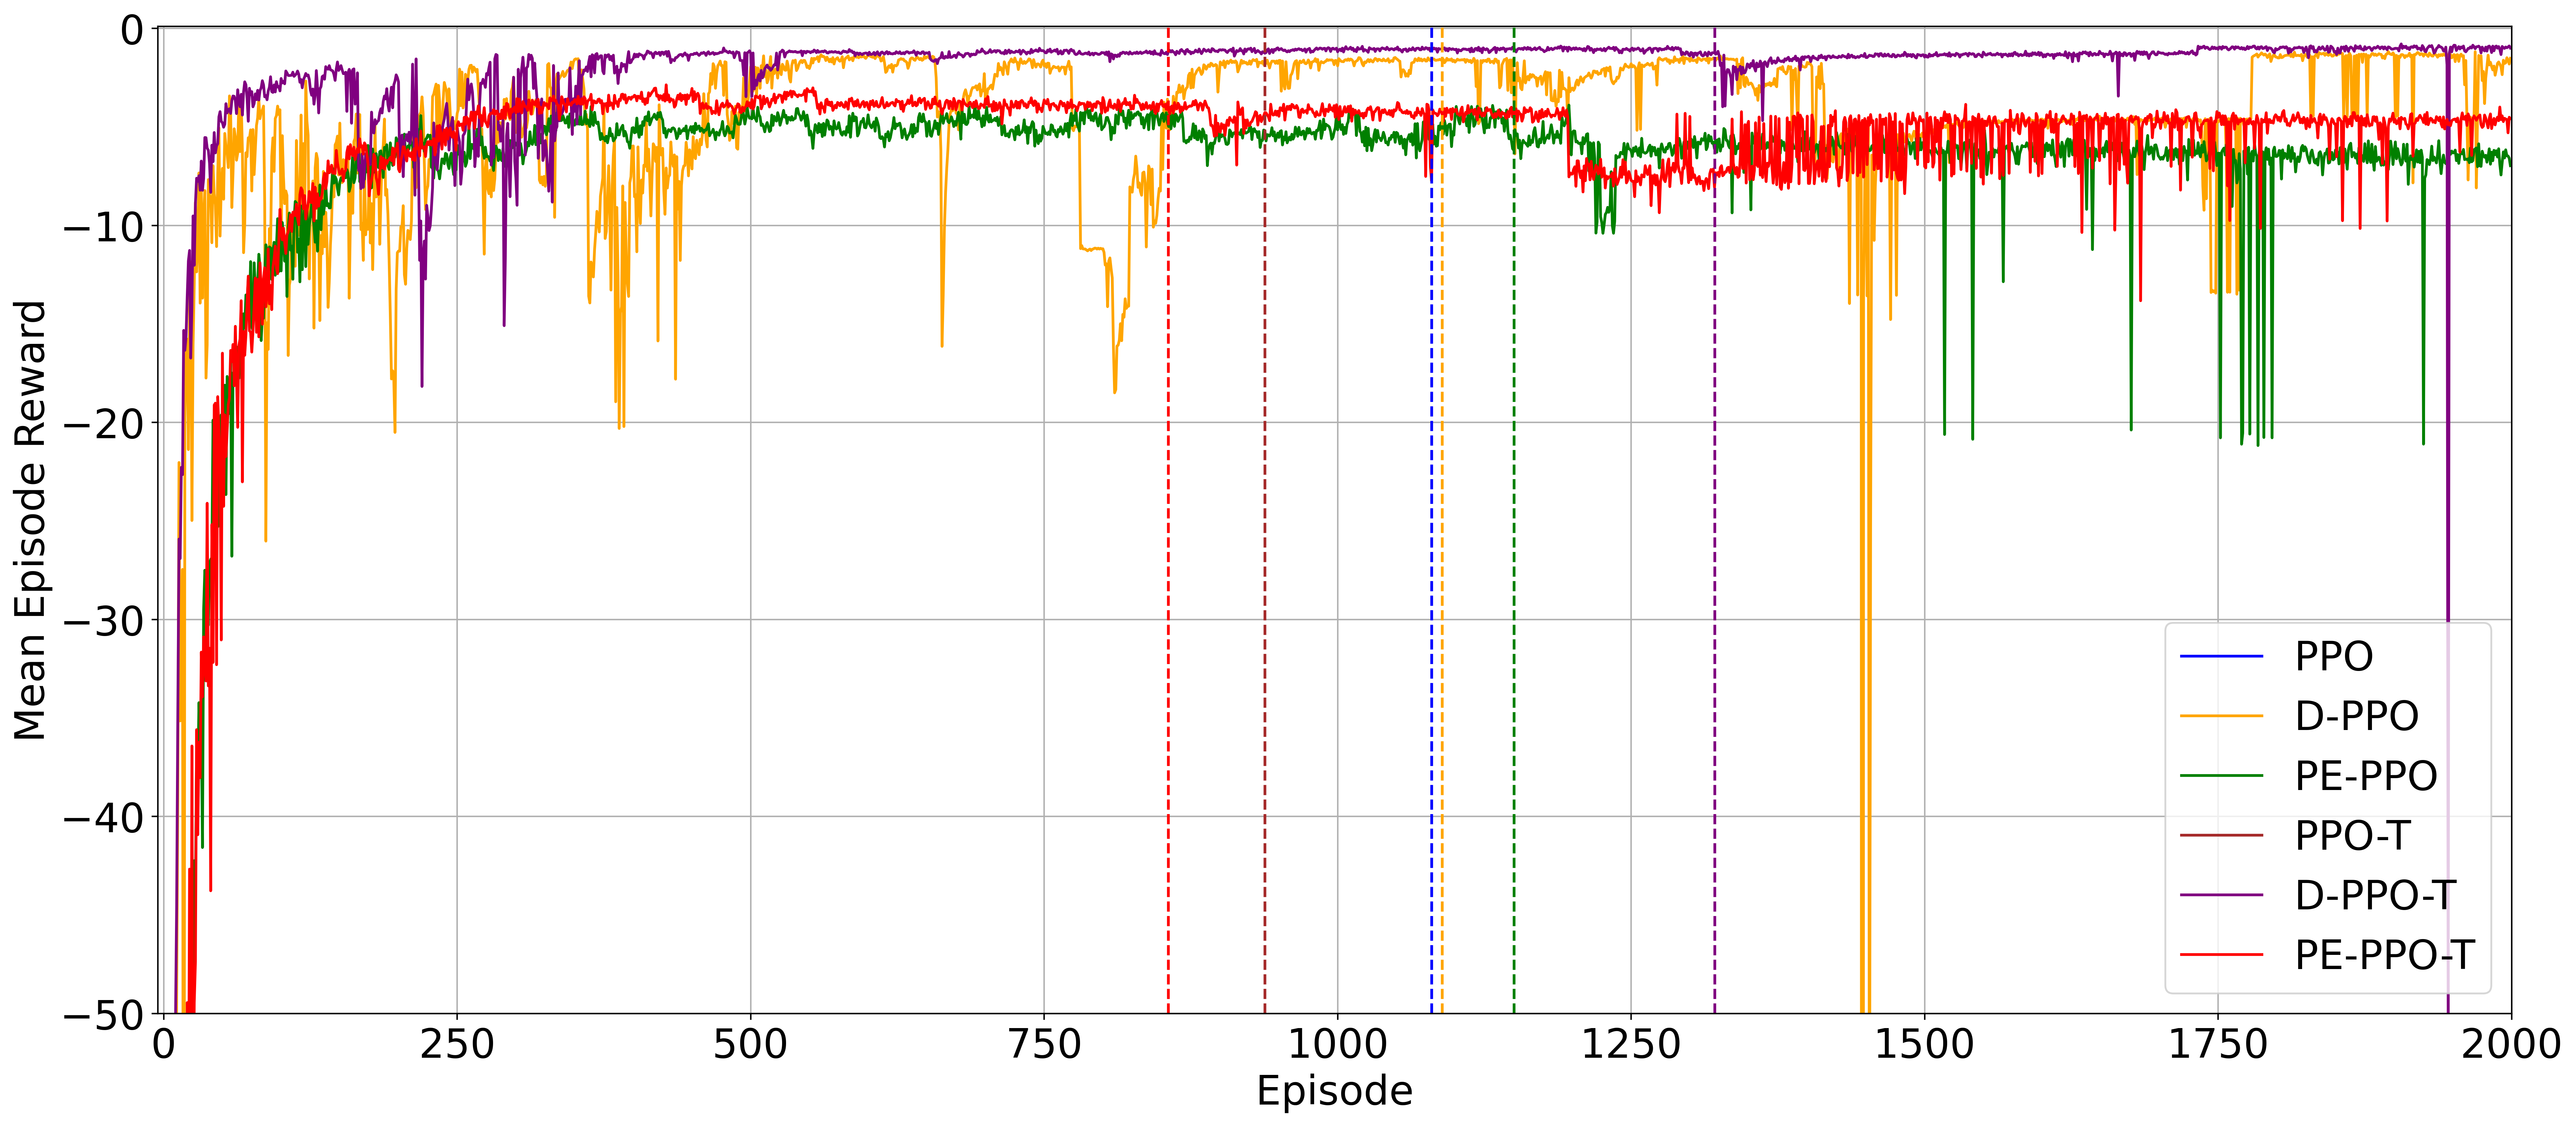

In [9]:
fig = plt.figure(figsize=(20, 9))
plt.plot(smoothMean(rewardDF.loc[evalRewardDF['name'] == 'PPO'], 2), color='blue')
plt.plot(smoothMean(rewardDF.loc[evalRewardDF['name'] == 'DPPO'], 2), color='orange')
plt.plot(smoothMean(rewardDF.loc[evalRewardDF['name'] == 'MAPPO'], 2), color='green')
plt.plot(smoothMean(rewardDF.loc[evalRewardDF['name'] == 'TPPO'], 2), color='brown')
plt.plot(smoothMean(rewardDF.loc[evalRewardDF['name'] == 'TDPPO'], 2), color='purple')
plt.plot(smoothMean(rewardDF.loc[evalRewardDF['name'] == 'TMAPPO'], 2), color='red')

for x, style in zip(compNamesDF['bestEvalEp', 'mean'],  ['orange', 'green', 'blue', 'purple', 'red', 'brown']):
    plt.axvline(x, color=style, linestyle='--')

plt.xlim((-5, 2000))
plt.ylim((-5e1, 0.1))

plt.legend(['PPO', 'D-PPO', 'PE-PPO', 'PPO-T', 'D-PPO-T', 'PE-PPO-T'])
plt.xlabel('Episode')
plt.ylabel('Mean Episode Reward') 
plt.grid()
plt.savefig('results/meanEpisodeReward.png')
fig

In [10]:
expDF.style.apply(highlight, subset=['bestTestScore', 'meanTestScore', 'bestEvalScore', 'bestEvalEp'])

,name,iteration,size,horizon,bestTestScore,bestTestIdx,meanTestScore,bestEvalScore,bestEvalEp
0,PPO,2,b,3,-0.305179,0,-0.387020,-0.305496,1410
1,PPO,6,b,3,-0.222762,9,-0.306581,-0.375327,1080
2,PPO,5,b,3,-0.082523,0,-0.096200,-0.103988,1930
3,PPO,0,b,3,-1.045058,7,-1.458443,-1.851763,440
4,PPO,1,b,3,-0.077195,0,-0.092492,-0.094964,1650
5,PPO,4,b,3,-0.110277,9,-0.145212,-0.202337,1050
6,PPO,3,b,3,-0.773756,4,-1.153552,-0.903808,670
7,PPO,7,b,3,-0.596077,7,-0.684379,-0.637112,780
8,DPPO,2,b,3,-0.000637,3,-0.002928,-0.000466,920
9,DPPO,6,b,3,-0.000794,0,-0.001697,-0.000922,340
